In [1]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [2]:
class VectorQuantizer(nn.Module):
    def __init__(self, in_channels, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.conv = nn.Conv2d(in_channels, embedding_dim, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings, embedding_dim) # (ne, ed)     
    
    def forward(self, z):
        # z is the output of the encoder
        # z: (b, c, h, w)
        B, C, H, W = z.shape
        z_e = self.conv(z) # (b, c, h, w) -> (b, ed, h, w)
        z_e = z_e.permute(0, 2, 3, 1).contiguous()
        flattened = z_e.view(-1, self.embedding_dim)
        # computing distance from z_e to the embedding space
        distances = (
                flattened.pow(2).sum(1, keepdim=True) # (b*h*w, 1)
                + self.embedding.weight.pow(2).sum(1) # (ne)
                - 2 * flattened @ self.embedding.weight.t() # (b*h*w, ne)
        ) # (b*h*w, ne)
        idxs = distances.argmin(1) # assigning each row of z_e to its nearest embedding
        z_q = self.embedding(idxs).view(B, H, W, self.embedding_dim) # (b*h*w, ed) - > (b, h, w, ed)
        e_latent_loss = F.mse_loss(z_q.detach(), z_e)
        q_latent_loss = F.mse_loss(z_q, z_e.detach())
        latent_loss = q_latent_loss + self.commitment_cost * e_latent_loss
        z_q = z_e + (z_q - z_e).detach() # grad flows through z_e during backprop 
        z_q = z_q.permute(0, 3, 1, 2).contiguous() # (b, h, w, ed) -> (b, ed, h, w)
        return z_q, latent_loss, idxs

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, n_hid):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_channels, n_hid, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hid, input_channels, 1),
        )

    def forward(self, x):
        return F.relu(x + self.layers(x))

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_channels, n_hid):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_channels, n_hid, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hid, 2*n_hid, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(2*n_hid, 2*n_hid, 3, padding=1),
            nn.ReLU(),
            ResidualBlock(2*n_hid, 2*n_hid//4),
            ResidualBlock(2*n_hid, 2*n_hid//4),
        )
        self.out_channels = 2*n_hid

    def forward(self, x):
        return self.layers(x)

In [5]:
class Decoder(nn.Module):
    def __init__(self, in_channels, n_hid, output_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, 2*n_hid, 3, padding=1),
            nn.ReLU(),
            ResidualBlock(2*n_hid, 2*n_hid//4),
            ResidualBlock(2*n_hid, 2*n_hid//4),
            nn.ConvTranspose2d(2*n_hid, n_hid, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(n_hid, output_channels, 4, stride=2, padding=1),
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
class VQVAE(nn.Module):
    def __init__(self, in_channels, n_hid, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.enc = Encoder(in_channels, n_hid)
        self.vq = VectorQuantizer(self.enc.out_channels, num_embeddings, embedding_dim, commitment_cost)
        self.dec = Decoder(embedding_dim, n_hid, in_channels)

    def forward(self, x):
        z = self.enc(x)
        z_q, latent_loss, idxs = self.vq(z)
        encodings = F.one_hot(idxs, self.vq.num_embeddings).float() # (b*h*w, ne)
        avg_probs = encodings.mean(0) # tells how often the embedding is used
        # if perplexity == num_embeddings then all embeddings are used exactly equally
        perplexity = (-(avg_probs * torch.log(avg_probs + 1e-10)).sum()).exp()
        x_hat = self.dec(z_q)
        return x_hat, latent_loss, perplexity

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 100
batch_size = 64
in_channels = 3
n_hid = 64
num_embeddings = 512
embedding_dim = 64
commitment_cost = 0.25
lr = 3e-4
transform = T.Compose(
    [
     T.RandomHorizontalFlip(),
     T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    ]
)
print(device)

cuda


In [8]:
train_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
val_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
data_var = np.var(train_data.data / 255.0) #0.06327039811675479, from DeepMind's code
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=True)
x, y = next(iter(train_loader))
print(len(train_data), len(val_data), data_var, x.shape, y.shape)

Files already downloaded and verified
Files already downloaded and verified
50000 10000 0.06328692405746414 torch.Size([64, 3, 32, 32]) torch.Size([64])


In [9]:
vqvae = VQVAE(in_channels, n_hid, num_embeddings, embedding_dim, commitment_cost).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=lr)

In [10]:
def loop(epoch, net, loader, is_train):
    net.train(is_train)
    losses = []
    perplexities = []
    pb = tqdm(loader, total=len(loader))
    for x, _ in pb:
        x = x.to(device)
        with torch.set_grad_enabled(is_train):
            x_hat, latent_loss, perplexity = net(x)
            recon_loss = ((x - x_hat) ** 2).mean() / (2 * data_var)
            loss = latent_loss + recon_loss
            losses.append(loss.item())
            perplexities.append(perplexity.item())
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pb.set_description(f"epoch={epoch}, train={is_train}")
        pb.set_postfix(avg_loss=f"{np.mean(losses):.4f}", avg_ppl=f"{np.mean(perplexities):.4f}")

In [11]:
for epoch in range(n_epochs):
    loop(epoch, vqvae, train_loader, True)
    loop(epoch, vqvae, val_loader, False)

epoch=99, train=False: 100%|██████████| 157/157 [00:03<00:00, 41.39it/s, avg_loss=0.1768, avg_ppl=40.0193]


In [12]:
def plot_examples(loader):
    vqvae.eval()
    x, _ = next(iter(loader))
    x = x.to(device)
    with torch.no_grad():
        x_hat = vqvae(x)[0]
    rows = torch.cat([x, x_hat], axis=2)
    imgs = torch.cat([rows[i] for i in range(52, 62)], axis=2).permute(1, 2, 0).cpu().detach() + 0.5
    plt.figure(figsize=(20, 5))
    plt.imshow(imgs)
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


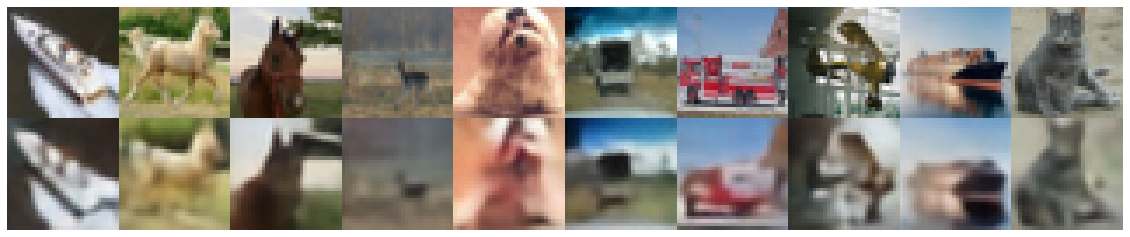

In [15]:
plot_examples(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


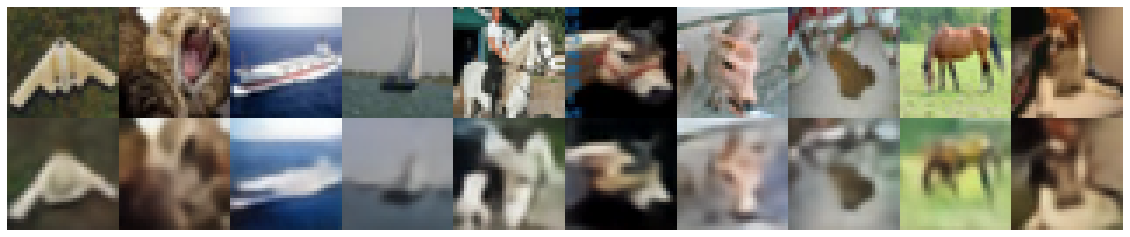

In [14]:
plot_examples(val_loader)